# Lagged forecast
This notebook forecasts each step of a dataset up to horizon steps into the future and compares the predictions with the actual values. This approach provides a clear visual assessment of the model's predictive accuracy.

Be sure to have extra libraries installed:

!pip install matplotlib

In [3]:
import jax.numpy as jnp
import jax.random as jr
from gradvar.gradvar import GradVAR
from gradvar.earlystopping import EarlyStopping
import matplotlib.pyplot as plt
jnp.set_printoptions(suppress=True)

In [4]:
def generate_sinusoidal_data(T, noise_std=0.05, key=jr.PRNGKey(0)):
    """ Generate a 2D time series: one sine and one cosine wave with noise """
    t1 = jnp.linspace(-jnp.pi * 8, jnp.pi * 8, T)
    t2 = jnp.linspace(-jnp.pi * 2, jnp.pi * 2, T)
    t3 = jnp.linspace(-jnp.pi * 4, jnp.pi * 4, T)
    noise = noise_std * jr.normal(key, (3, T))
    Y = jnp.stack([jnp.sin(t1)*0.5, jnp.cos(t2), jnp.sin(t3) + jnp.sin(t3*1.5)]) + noise
    return Y.T

## Example data
We generate a sinusoidal dataset $Y$ with some added noise, where data is inputted as a matrix of $m \times n$ where $m$ is the time dimension (rows) with $t_0$ being the first row, and $n$ the signal columns.

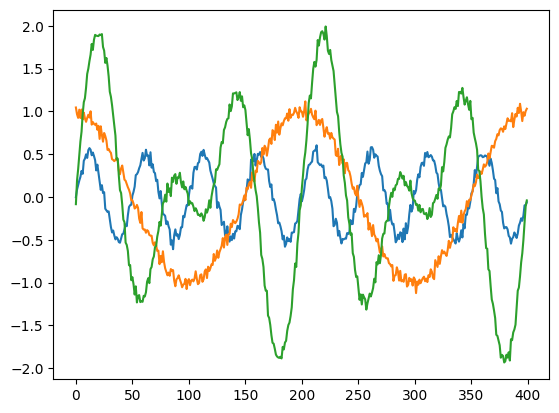

In [5]:
# Generate sinusoidal dataset
key = jr.PRNGKey(42)
T = 400
Y = generate_sinusoidal_data(T, noise_std=0.05, key=key)
plt.plot(Y)
plt.show()

## Training
The `train()`-function prepares the input dataset using the `p`-parameter (number of lags), and train the VAR model up until the number of epochs specified. Alternatively, as done here, we can define and early stopping scheme where we stop training when the losses flattens out.

In [6]:
av = GradVAR()
losses = av.train(Y, p=50, learning_rate=0.001, num_epochs=10000, early_stopping = EarlyStopping(patience=30, min_delta=1e-5))

  4%|▍         | 425/10000 [00:07<02:40, 59.48it/s]


We can now plot the loss curve and determine convergency, as we see the curve flattens and training terminates early:

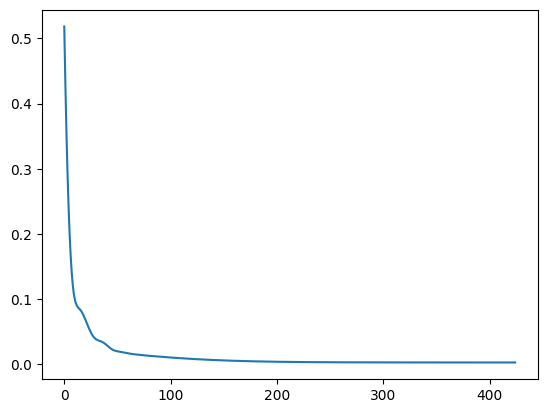

In [7]:
plt.plot(losses)
plt.show()

## Forecasting with the model
The lagged forecast iterates of the last $p$ lags and generate a forecast $horizon$ steps in the future. The last forecast will be recorded and visually compared with the actual data. This is a good way to determine the predictability of a model at different settings of $horizon$, in a visual way. 

In [8]:
horizon = 25
Y_forecast = av.lagged_forecast(Y, horizon)

100%|██████████| 324/324 [00:11<00:00, 27.73it/s]


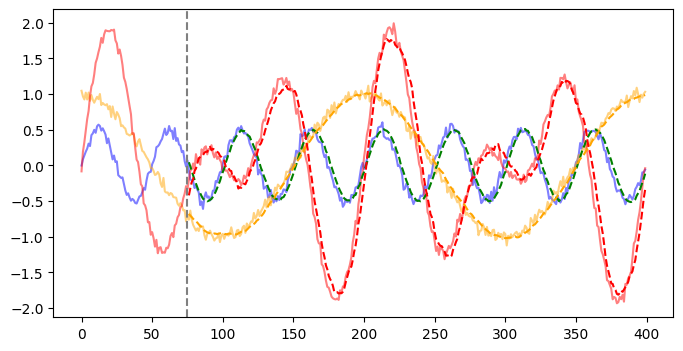

In [9]:
x_data = jnp.arange(len(Y))

plt.figure(figsize=(8, 4))
plt.plot(x_data, Y[:,0], color='blue', alpha=0.5)
plt.plot(x_data, Y[:,1], color='orange',alpha=0.5)
plt.plot(x_data, Y[:,2], color='red', alpha=0.5)
plt.plot(x_data, Y_forecast[:,0], color='green', linestyle='--')
plt.plot(x_data, Y_forecast[:,1], color='orange', linestyle='--')
plt.plot(x_data, Y_forecast[:,2], color='red', linestyle='--')

plt.axvline(x=av.p+horizon, color='gray', linestyle='dashed', label="Forecast Start")
plt.show()